
# *Momentum Strategy Backtest* :

Level : **1**

Auteur : **ZEKOVIX**

Objectif : **Backtest of a Momentum Strategy on U.S. Indexes**

In [13]:
#First step import libraries and datas
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8-darkgrid")

tickers = ["^GSPC", "^DJI", "^IXIC"]  # S&P 500, Dow Jones, Nasdaq

raw = yf.download(tickers,start="2018-01-01",end="2025-11-01",auto_adjust=True,progress=False)

prices = raw["Close"].dropna(how="all")

print(prices.shape)
prices.round(2).tail()



(1970, 3)


Ticker,^DJI,^GSPC,^IXIC
Date,,,
2025-10-27,47544.59,6875.16,23637.46
2025-10-28,47706.37,6890.89,23827.49
2025-10-29,47632.00,6890.59,23958.47
2025-10-30,47522.12,6822.34,23581.14
2025-10-31,47562.87,6840.20,23724.96


In [20]:
#Second step : now that we have extracted the datas that we needed, we are going to compute daily returns

In [17]:
# Calculate daily returns
daily_returns = prices.pct_change().dropna()

# Round to 4 decimals for readability
returns = daily_returns.round(4)

# Display the last 5 rows
returns.tail()

Ticker,^DJI,^GSPC,^IXIC
Date,,,
2025-10-27,0.0071,0.0123,0.0186
2025-10-28,0.0034,0.0023,0.0080
2025-10-29,-0.0016,-0.0000,0.0055
2025-10-30,-0.0023,-0.0099,-0.0157
2025-10-31,0.0009,0.0026,0.0061


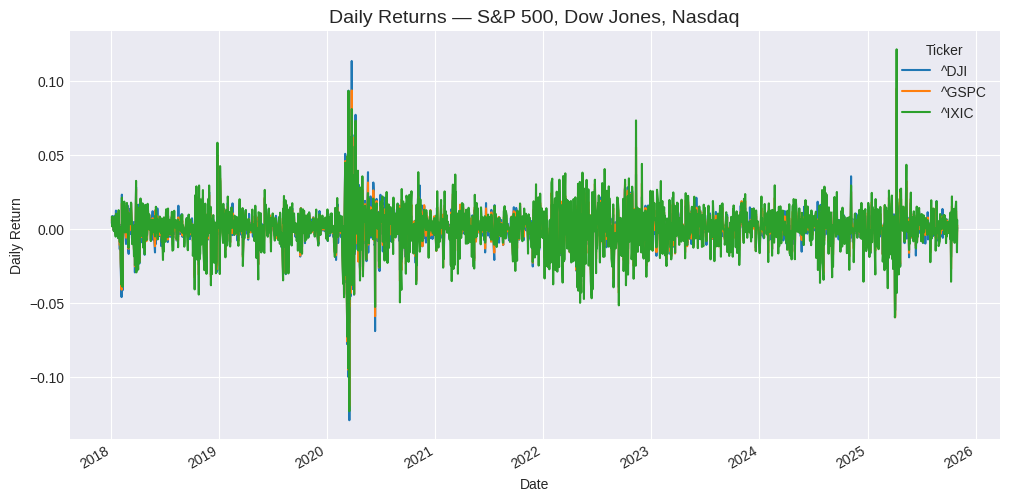

In [18]:
returns.plot(figsize=(12,6))
plt.title("Daily Returns — S&P 500, Dow Jones, Nasdaq", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Daily Return")
plt.show()

In [22]:
#Step 3A — Calculate Momentum

#Momentum calculation (20-day lookback)
lookback = 20
momentum = prices / prices.shift(lookback) - 1

#Round for readability
momentum = momentum.round(4)

#Display the last few values
momentum.tail()


Ticker,^DJI,^GSPC,^IXIC
Date,,,
2025-10-27,0.0265,0.0321,0.0463
2025-10-28,0.0282,0.0303,0.0515
2025-10-29,0.0256,0.0267,0.0529
2025-10-30,0.0215,0.0159,0.0323
2025-10-31,0.0172,0.0185,0.0415


In [23]:
#Step 3B — Creating the Trading Signal
#We’ll now define our trading rule:
#If momentum > 0 → we go long (buy)
#If momentum ≤ 0 → we stay out (no position)

#Trading signal: 1 if momentum positive, else 0
signal = (momentum > 0).astype(int)

signal.tail()



Ticker,^DJI,^GSPC,^IXIC
Date,,,
2025-10-27,1,1,1
2025-10-28,1,1,1
2025-10-29,1,1,1
2025-10-30,1,1,1
2025-10-31,1,1,1


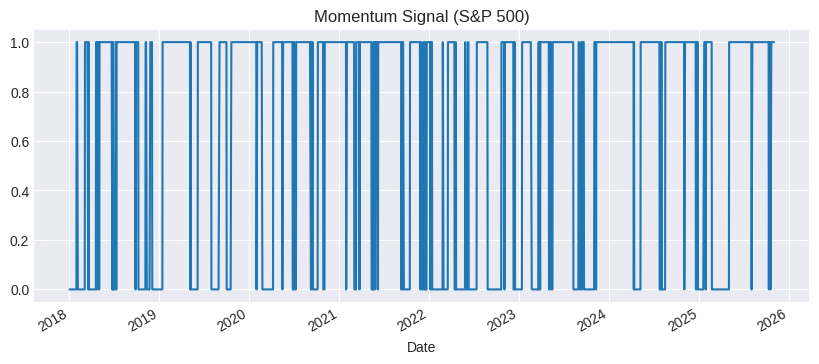

In [25]:
#Step 3C — Quick Sanity Check

plt.figure(figsize=(10,4))
signal["^GSPC"].plot(title="Momentum Signal (S&P 500)")
plt.show()


In [26]:
#Step 4A — Compute cumulative returns

#Compute cumulative returns (growth of $1)
cumulative_returns = (1 + returns).cumprod()

#Round for readability
cumulative_returns = cumulative_returns.round(2)

#Display the last few rows
cumulative_returns.tail()

Ticker,^DJI,^GSPC,^IXIC
Date,,,
2025-10-27,1.91,2.55,3.38
2025-10-28,1.92,2.55,3.40
2025-10-29,1.92,2.55,3.42
2025-10-30,1.91,2.53,3.37
2025-10-31,1.92,2.53,3.39


In [27]:
#That means $1 invested in 2018 is now worth $1.92 in the Dow, $2.53 in the S&P 500, and $3.39 in the Nasdaq.

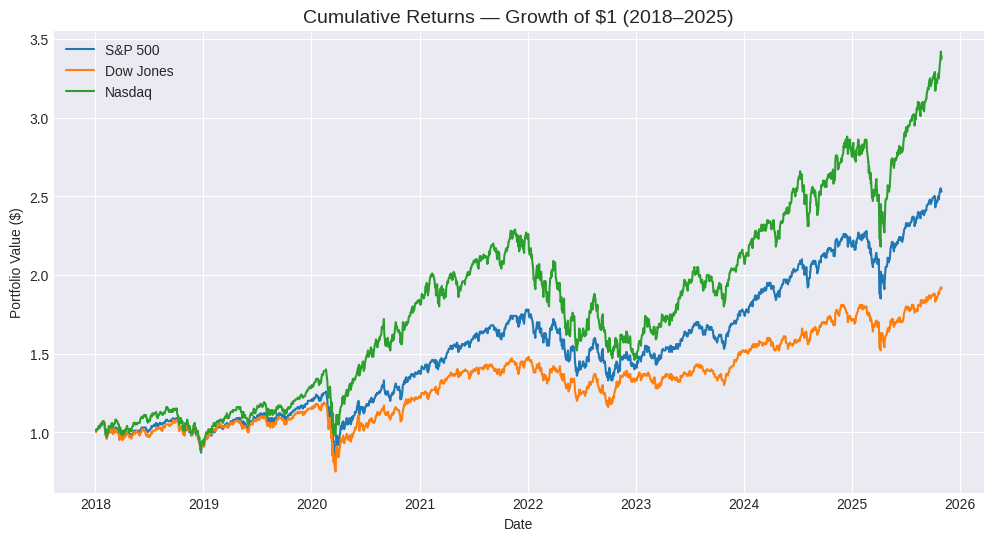

In [29]:
#Step 4B

plt.figure(figsize=(12,6))
plt.plot(cumulative_returns["^GSPC"], label="S&P 500")
plt.plot(cumulative_returns["^DJI"], label="Dow Jones")
plt.plot(cumulative_returns["^IXIC"], label="Nasdaq")
plt.title("Cumulative Returns — Growth of $1 (2018–2025)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.legend()
plt.show()

In [30]:
# Step 5 A — Strategy daily returns

position = signal.shift(1)
strategy_returns = (position * returns).mean(axis=1)
strategy_returns = strategy_returns.dropna()

In [31]:
# Step 5 B — Benchmark
benchmark_returns = returns.mean(axis=1).loc[strategy_returns.index]

In [32]:
# Step 5 C — Cumulative curves
eq_strategy  = (1 + strategy_returns).cumprod()
eq_benchmark = (1 + benchmark_returns).cumprod()


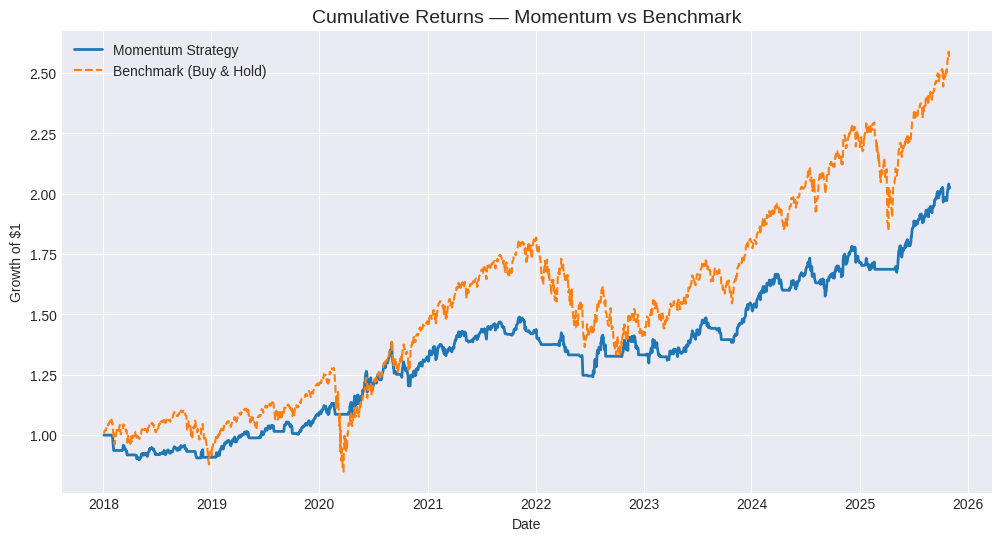

In [33]:
# Plot

plt.figure(figsize=(12,6))
plt.plot(eq_strategy,  label="Momentum Strategy", linewidth=2)
plt.plot(eq_benchmark, label="Benchmark (Buy & Hold)", linestyle="--")
plt.title("Cumulative Returns — Momentum vs Benchmark", fontsize=14)
plt.xlabel("Date"); plt.ylabel("Growth of $1")
plt.legend(); plt.show()

In [37]:
#Final step - we need the Performance Metrics

# Strategy performance
def sharpe_ratio(r, rf=0.0):
    return (r.mean() - rf) / r.std() * np.sqrt(252)

def max_drawdown(equity_curve):
    peak = equity_curve.cummax()
    dd = equity_curve / peak - 1
    return dd.min()

ann_return = (1 + strategy_returns.mean())**252 - 1
ann_vol = strategy_returns.std() * np.sqrt(252)
sharpe = sharpe_ratio(strategy_returns)
mdd = max_drawdown(eq_strategy)

print("\n=== Strategy (Momentum) ===")
print(f"Annualized Return: {ann_return:.2%}")
print(f"Annualized Volatility: {ann_vol:.2%}")
print(f"Sharpe Ratio: {sharpe:.2f}")
print(f"Max Drawdown: {mdd:.2%}")

# Benchmark performance
ann_return_bm = (1 + benchmark_returns.mean())**252 - 1
ann_vol_bm = benchmark_returns.std() * np.sqrt(252)
sharpe_bm = sharpe_ratio(benchmark_returns)
mdd_bm = max_drawdown(eq_benchmark)

print("\n=== Benchmark (Buy & Hold) ===")
print(f"Annualized Return: {ann_return_bm:.2%}")
print(f"Annualized Volatility: {ann_vol_bm:.2%}")
print(f"Sharpe Ratio: {sharpe_bm:.2f}")
print(f"Max Drawdown: {mdd_bm:.2%}")


=== Strategy (Momentum) ===
Annualized Return: 10.14%
Annualized Volatility: 11.05%
Sharpe Ratio: 0.87
Max Drawdown: -16.60%

=== Benchmark (Buy & Hold) ===
Annualized Return: 15.22%
Annualized Volatility: 20.30%
Sharpe Ratio: 0.70
Max Drawdown: -33.60%


The results highlight the different risk–return profiles of the two strategies. While the **Buy & Hold** benchmark achieved a higher **annualized return (15.22%)**, it came with a significantly larger **maximum drawdown (-33.60%)**, exposing the investor to deeper losses during market downturns. In contrast, the **Momentum strategy** delivered a more moderate **annualized return (10.14%)**, but with a much smaller **drawdown (-16.60%)**, showing its ability to preserve capital during volatile periods. Its **Sharpe ratio (0.87)** also exceeds that of Buy & Hold (0.70), indicating **superior risk-adjusted performance** — the strategy generates more return per unit of risk taken. Although slightly more volatile overall (11.05% vs. 10.30%), the momentum approach provides smoother, more stable growth and offers a compelling trade-off between performance and risk management.


In [38]:
# Interesting alternantive - Step 7 — 6-Month Momentum Version (long-term momentum)

lookback_6m = 126  # ~6 months of trading days
momentum_6m = prices / prices.shift(lookback_6m) - 1
momentum_6m = momentum_6m.round(4)

In [39]:
# Create signal for 6-month momentum
signal_6m = (momentum_6m > 0).astype(int)

In [40]:
# Compute 6-month strategy returns
position_6m = signal_6m.shift(1)
strategy_returns_6m = (position_6m * returns).mean(axis=1).dropna()

In [41]:
# Compute cumulative returns
eq_strategy_6m = (1 + strategy_returns_6m).cumprod()

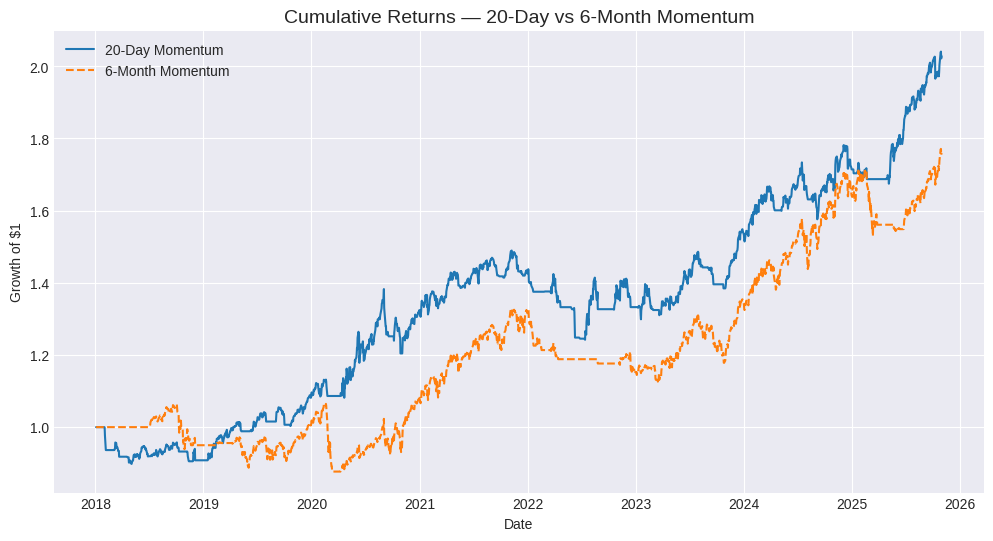

In [42]:
# Plot comparison with 20-day strategy
plt.figure(figsize=(12,6))
plt.plot(eq_strategy,    label="20-Day Momentum")
plt.plot(eq_strategy_6m, label="6-Month Momentum", linestyle="--")
plt.title("Cumulative Returns — 20-Day vs 6-Month Momentum", fontsize=14)
plt.xlabel("Date"); plt.ylabel("Growth of $1")
plt.legend(); plt.show()

In [43]:
def sharpe_ratio(r, rf=0.0):
    return (r.mean() - rf) / r.std() * np.sqrt(252)

def max_drawdown(equity_curve):
    peak = equity_curve.cummax()
    dd = equity_curve / peak - 1
    return dd.min()

ann_return = (1 + strategy_returns_6m.mean())**252 - 1
ann_vol = strategy_returns_6m.std() * np.sqrt(252)
sharpe = sharpe_ratio(strategy_returns_6m)
mdd = max_drawdown(eq_strategy)

print("\n=== Strategy_6m (Momentum) ===")
print(f"Annualized Return: {ann_return:.2%}")
print(f"Annualized Volatility: {ann_vol:.2%}")
print(f"Sharpe Ratio: {sharpe:.2f}")
print(f"Max Drawdown: {mdd:.2%}")


=== Strategy_6m (Momentum) ===
Annualized Return: 8.25%
Annualized Volatility: 11.73%
Sharpe Ratio: 0.68
Max Drawdown: -16.60%
